# Pixel induced current
In this notebook we load a track dataset and we calculate the current induced on the pixels placed at the anode.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts, quenching, drifting, detsim, pixels_from_track
import importlib
importlib.reload(drifting)
importlib.reload(quenching)
importlib.reload(consts)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

import pickle
import numpy as np
import numba as nb
import pandas as pd
from numba import cuda
from math import ceil, sqrt, pi, exp, erf
from time import time

Here we load the dataset with the tracks and we store the column cols corresponding to the each variable.

In [3]:
tracks_dict = pickle.load(open('edepsimDataset.p', 'rb'))
tracks = pd.DataFrame.from_dict(tracks_dict)
tracks['t'] = 0.
tracks['t_start'] = 0.
tracks['t_end'] = 0.
tracks['x_start'] = tracks_dict['z_start'] 
tracks['z_start'] = tracks_dict['x_start'] 
tracks['x_end'] = tracks_dict['z_end'] 
tracks['z_end'] = tracks_dict['x_end'] 

tracks['z_start'] /= 1e2
tracks['z_end'] /= 1e2
tracks['y_start'] /= 1e2
tracks['y_end'] /= 1e2
tracks['x_start'] /= 1e2
tracks['x_end'] /= 1e2

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0.
tracks['longDiff'] = 0.
tracks['tranDiff'] = 0.

tracks_np = tracks.to_numpy()
cols = nb.typed.Dict()
for i, c, in enumerate(tracks.columns):
    cols[c] = i

tracks_np = np.ascontiguousarray(tracks_np)
d_tracks_np = cuda.to_device(tracks_np)

/global/homes/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


In [4]:
threadsperblock = 128
blockspergrid = ceil(tracks_np.shape[0] / threadsperblock)
quenching.GPU_Quench[threadsperblock,blockspergrid](d_tracks_np, consts.box)
drifting.GPU_Drift[threadsperblock,blockspergrid](d_tracks_np)

## Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [20]:
nn = np.logspace(0,2,10,dtype=np.int32)
times_gpu = []
times_gpu_memory = []

for n in nn:
    selected_tracks = d_tracks_np[:n]
    threadsperblock = 128
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    
    active_pixels = np.zeros(shape=(selected_tracks.shape[0], 10, 2))
    neighboring_pixels = np.full((selected_tracks.shape[0], 70, 2), -1)
    n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))

    pixels_from_track.get_pixels[threadsperblock,blockspergrid](selected_tracks, 
                                                                active_pixels, 
                                                                neighboring_pixels, 
                                                                n_pixels_list)
    signals = np.zeros((selected_tracks.shape[0], 
                        neighboring_pixels.shape[1], 
                        anode_t.shape[0]), dtype=np.float32)
    threadsperblock = (128,128,128)
    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    slice_size = 20
    start = time()
    d_signals = cuda.to_device(signals)
    d_pixels = cuda.to_device(neighboring_pixels)
    d_selected_tracks = cuda.to_device(selected_tracks)
    d_anode_t = cuda.to_device(anode_t)
    start_nomemory = time()
    detsim.tracks_current[threadsperblock, blockspergrid](d_signals, 
                                                          d_pixels, 
                                                          d_selected_tracks, 
                                                          slice_size)
    end_nomemory = time()
    end = time()
    times_gpu.append(end_nomemory-start_nomemory)
    times_gpu_memory.append(end-start)

In [21]:
nn_cpu = np.logspace(0,3,10,dtype=np.int32)
times_cpu = [0.01742410659790039,
             0.050868988037109375,
             0.059677839279174805,
             0.12185907363891602,
             0.23131489753723145,
             0.48302698135375977,
             1.0946669578552246,
             2.4459469318389893,
             5.015509843826294,
             11.755344152450562]

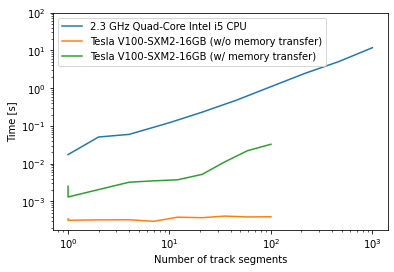

In [22]:
plt.plot(nn_cpu,times_cpu,label='2.3 GHz Quad-Core Intel i5 CPU')
plt.plot(nn, times_gpu, label='%s (w/o memory transfer)' 
                              % cuda.cudadrv.driver.Device(0).name.decode())
plt.plot(nn, times_gpu_memory, label='%s (w/ memory transfer)'
                                     % cuda.cudadrv.driver.Device(0).name.decode())
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=1e2)
plt.xlabel("Number of track segments")
plt.ylabel("Time [s]")
_ = plt.legend()

In [23]:
float_array = nb.types.float32[::1]
pixelID_type = nb.types.Tuple((nb.int64, nb.int64))
signal_type = nb.types.ListType(nb.types.Tuple((nb.float64, nb.float64, float_array)))
active_pixels = detsim.join_pixel_signals(d_signals.copy_to_host(), neighboring_pixels)

In [24]:
currents = np.array([sum(detsim.pixel_response(active_pixels[p], anode_t)) for p in active_pixels.keys()])

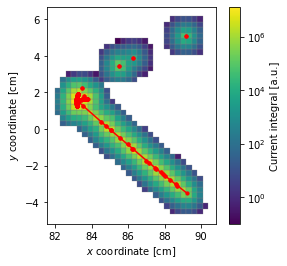

In [25]:
norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1)
for i,p in enumerate(active_pixels.keys()):
    if currents[i]:
        rect = plt.Rectangle(((p[0])*consts.pixel_size[0]+consts.tpc_borders[0][0],
                              (p[1])*consts.pixel_size[1]+consts.tpc_borders[1][0]),
                             consts.pixel_size[0],consts.pixel_size[1],
                             linewidth=0.3,
                             edgecolor='grey', 
                             facecolor=m.to_rgba(currents[i]), label='Pixel')
        ax.add_patch(rect)
    
for t in selected_tracks:
    ax.plot((t[cols['x_start']], t[cols['x_end']]), 
            (t[cols['y_start']], t[cols['y_end']]),
            c='r',
            zorder=10)
    ax.scatter((t[cols['x_start']], t[cols['x_end']]), 
               (t[cols['y_start']], t[cols['y_end']]),
               c='r',
               s=10,
               zorder=10)

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_aspect("equal")
_ = plt.colorbar(m,fraction=0.046, pad=0.04, label='Current integral [a.u.]')

Text(0, 0.5, 'Current [a.u.]')

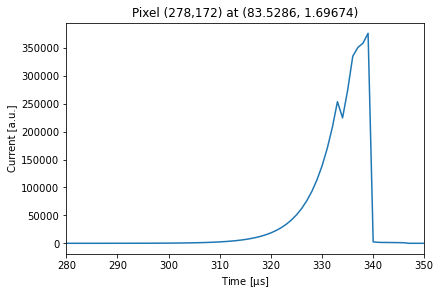

In [26]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
pixelID = detsim.pixel_from_coordinates(83.6,1.8,consts.n_pixels)
current = detsim.pixel_response(active_pixels[pixelID], anode_t)
ax.plot(anode_t, current, label='Current')
ax.set_xlim(280,350)  
# ax.set_yscale("log")
ax.set_title("Pixel (%i,%i) at (%g, %g)" % (pixelID[0], pixelID[1], 
                                            (pixelID[0] + consts.pixel_size[0]/2)*consts.pixel_size[0]+consts.tpc_borders[0][0], 
                                            (pixelID[1] + consts.pixel_size[0]/2)*consts.pixel_size[1]+consts.tpc_borders[1][0]))
ax.set_xlabel("Time [$\mathrm{\mu}$s]")
ax.set_ylabel("Current [a.u.]")